In [1]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)
import seaborn as sns

In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [12.0, 5.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})
sns.set(rc={'figure.figsize':(7,3)})

# Probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Probabilistic programming


* If prior and likelihood are not conjugate  the posterior is  untractable, in which case it has to be numerically sampled. Designing an appropriate sampling algorithm requires much expertise.


* Languages for *probabilistic programming* address this problem.


* They describe a probabilistic model in  few lines and  compute the posterior of the parameters (*inference*) automatically. 

# Probabilistic programming languages


* We  use PyMC3, a package for probabilistic programming under Python.

* You also the arviz package, which provides functions to analyze the posterior. 
    * Please install the latest version: `pip install arviz==0.12.1`


* Another  language for probabilistic programming is [Stan](https://mc-stan.org/).  This can be used to implement a custom model, or via the R packages ( [brms](https://cran.r-project.org/web/packages/brms/index.html) and  [rstanarm](https://mc-stan.org/rstanarm/))  which provide some pre-implemented models.

# Estimating the bias $\theta$ of the coin


* We start by generating   data with a known $\theta$ so that we can check the accuracy of our estimate.

In [3]:
#Generating the data
np.random.seed(123)
n_draws = 100
theta_real = .35  

#we generate the data (rvs stands for random-variates)
data = stats.bernoulli.rvs(p=theta_real, size=n_draws)

# the data are  a vector of 0 and 1; with this seed they contain 30 successes.
print(data)
print(sum(data))

[1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0]
30


# The beta-binomial model

* We consider  a flat prior for $\theta$:  Beta(1,1). 

* $y$ is the number of observed heads while $n$ is the number of draws.

* The likelihood is binomial:
    * $\operatorname{Bin}(y, p, n)$ is the probability of observing $y$ successes in $n$ independent trials, each with probability $p$.

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha=1, \beta=1)\\
y &\sim \operatorname{Bin}(n=n_{\text{draws}}
, p=\theta)
\end{align}

# The beta-binomial model

We can also consider an equivalent but slightly different parameterization:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha=1, \beta=1)\\
y_i &\sim \operatorname{Bernoulli}(\theta)
\end{align}

where $y_i$ denotes the outcome (0,1) of the i-th draw. In this case the data are a vector of 0s and 1s.

In [4]:
# Beta-binomial model in Pymc3
beta_binomial_model = pm.Model()

# The lines within the "with" statement refer to the same model 
with beta_binomial_model:
    #The first argument is  a string specifying the name of the random variable, which should
    #match the name of the Python variable.

    #Uniform prior, i.e., Beta(1,1) 
    theta = pm.Beta('theta', alpha=1, beta=1)  

    
    #Likelihood, characterized by the keyword  `observed`.
    #y = pm.Bernoulli('y', p=theta, observed=data)  # likelihood (one Bernoulli trial at a time)
    y = pm.Binomial('y',n=n_draws, p=theta, observed=sum(data)) # likelihood (y successes within n_draws experiments)

In [8]:
with beta_binomial_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


# Inference


*  Sampling from the posterior  is called *inference*. 


* We make  inference about the parameters, i.e., the unobserved variables to which we assigned a prior.


* In this case we make inference about $\theta$.


## Plotting the posterior with Arviz

* ArviZ is a Python package which analyzes the PyMC3 trace.


* We evaluate  the sampled posterior through ArviZ's `plot_trace` function.


* The `trace` contains  the sampled values of the unobserved variables, called *parameters*. In this case,  $\theta$ is the only parameter.




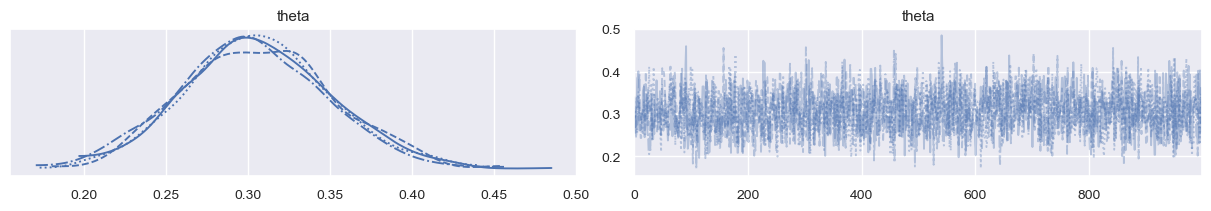

In [9]:

# We get two plots for theta:
# - on the  left a density plot (KDE, Kernel Density Estimation). The different lines refer to different MCMC chains run in parallel.
# - on the right the trace (the values sampled at each step). Also here the trace of different chains is shown (light blue vs dark blue)

# We can also see  the chains mix well  and that the density plot are smooth and overlap.

#the plot_trace function allows to visually check the quality of the sampling: 
#do the different chains providing a similar histogram?
# does the chain behave almost as white noise?
#is the histogram smooth?


import arviz as az
az.plot_trace(trace);

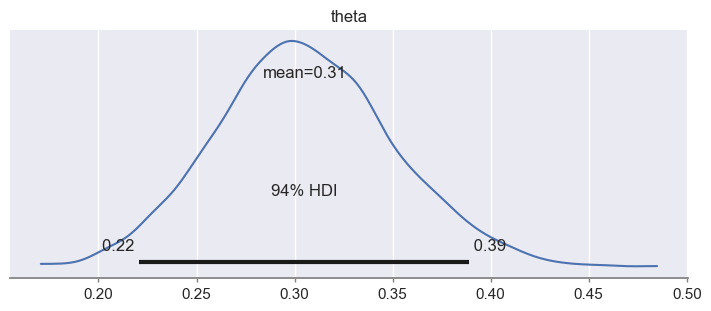

In [10]:
# the plot_posterior function is more concerned with the estimated values, it reports point estimate and HDI
# the posterior mean, computed analytically, is (1 + 30)/ (1 + 30 + 70 +1) = 0.303, almost identical to the value estimated by pymc3.
#The true theta which generates the data  is 0.35, which is well within the HDI.
az.plot_posterior(trace);

# Diagnosing  the chains 

<img src='img/trace-burn.png' width=400 align="center" >

* The values in the chain must be *representative* of the posterior distribution. 
* They should not be  influenced by the arbitrary initial value of the chain.
 > This figure and the following ones are from Krushke (Chap 7.5)

# Diagnosing  the chains

<img src='img/trace-burn.png' width=400 align="center" >

* It takes a few hundred steps for the three chains to converge to the same region of the parameter


* The first several hundred steps (*burn-in*) of the chain should be discarded as they are not representative.

# Removing the burn-in period
<img src="img/trace-convergence.png" width=500 >

* PyMC3 automatically removes the burn-in period.
* Once removed the burn-in period,   the three chains meander  smoothly and overlap each other (*good mixing*).
* The trace should look like white noise.



# Checking the  density plots


<img src='img/kde-no-convergence.png' width=500 >

* We compute a density plot on the samples from each chain.

* The density plots of the three chains do not overlap  well during the burn-in period: the chains have not converged.

# Density plots which overlap well 


<img src='img/kde-convergence.png' width=500 >

* This suggests that the chains contain representative values from the posterior distribution. 
* The HDI limits are slightly different for each chain because each chain is a finite random sample. 

# Poor mixing
<img src='img/chain-poor-mixing.png' width=500 style="display=block; margin:auto"/>

* The blue chain got stuck: it is a horizontal line for long number of samples.
* This is a problem: the sampler is only accepting  proposals in the very close neighborhood.
* It is thus sampling very slowly;  in  finite samples this prevents sampling the entire posterior,  biasing  the results.

# Effective sample size (ESS)

* The chains might be auto-correlated, i.e.,  the value samples at the current iteration is similar to the value sampled in the previous iteration.

* How much independent information is in the chains ?

* What would be the sample size of a completely non-autocorrelated chain that yielded the same information?

* The ESS estimates how many independent draws contain the same amount of information as the dependent sample obtained by MCMC sampling.


# ESS with high auto-correlation

<img src='img/ess-low.png' width=1000 >

# ESS with low auto-correlation

<img src='img/ess-high.png' width=1000 align="center" >

# Effective sample size (ESS)

*  The effective sample size divides the actual sample size by the amount of autocorrelation in the chain.

\begin{align}
\text{ESS}= \frac{N}{(1 + 2\sum_{k=1}^{k=\infty} ACF(k))}
\end{align}

where
$$
ACF(k)  = \operatorname{Cor}(\theta_t, \theta_{t+k})
$$

# Bulk and Tail Effective Sample Size

* The *Bulk Effective Sample Size* (ess_bulk) is a useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of mean and median estimates).

* The *Tail Effective Sample Size* (ess_tail) estimates  the effective sample sizes for 5% and 95% quantiles; it is thus a useful measure of sampling efficiency in the tails of the distribution 

* Both  should be at least  (approximately) 400,  in order to have be reliable  estimates of the related posterior quantiles. 

# A further diagnostic: Rhat

* If the chains have converged,  they should be very similar to one another; if not, one or more of the chains has failed to converge.

* Rhat thus compares the variance between chains with the variance within chains.  Ideally, Rhat = 1.

* It is ok if Rhat < 1.1; higher values signal a lack of convergence.

<img src='img/rhat-example.png' width=500 align="center" >

# Summarizing the posterior

The `az.summary` function show different information about  $\theta$:


* the mean, the standard deviation and the  HDI (whose desired coverage can be set via 'hdi_prob') 


* the effective number of samples for bulk and tail


* Rhat

In [11]:
#the actual theta is 0.35
#recall our prior is Beta(1,1); we have 30 successes in 100 trials.
#the posterior mean  is analytically (1+30)/(2+100)=0.303
#this is indeed very close to the posterior mean of our samples

#This is relatively far from 0.35, but the actual value is included in the 95% HDI.
#That is why HDI is more meaningful than a point estimate.

# The posterior  is well sampled:  rhat is 1,  both ess are high.
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.305,0.045,0.22,0.395,0.001,0.001,1640.0,2823.0,1.0


# Your turn

* Replace the beta distribution with a uniform one in the interval [0,1] and compare the results.


* Replace the beta distribution with a uniform one in the interval [0, 0.2] and compare the results.

Link to the documentation of the Uniform distributon in pymc: https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Uniform.html

  


# Reporting the posterior 

The `plot_posterior` function provides a visual summary of the posterior:

*  the density plot


* the mean of the distribution (we can have  the median or mode using the `point_estimate` argument; with asymmetric distribustions, the mode is more meaningful.) 


* the 95% HPD, whose coverage can be set the `alpha` argument. 

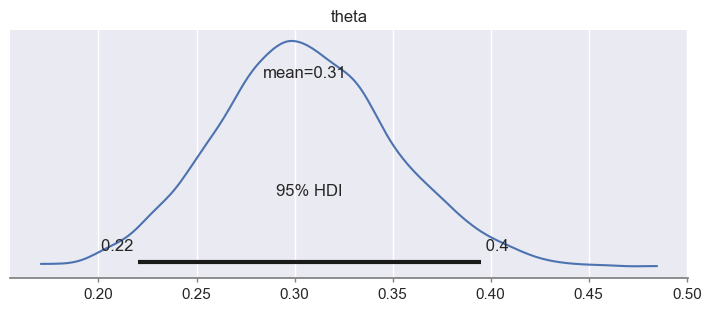

In [12]:
az.plot_posterior (trace, hdi_prob = 0.95);

## Decisions based on posterior

* Assume  we have to decide whether or not the coin is biased, i.e., if it lands heads with probability different from 0.5. 



* We thus check whether the reference value 0.5 is within  the HDI interval. 



* The 95% HDI interval goes from $\approx$ 0.16 to $\approx$ 0.41,  excluding 0.5. It rules out  the hypothesis of the coin being unbiased.

# ROPE

* The probability of  *exactly*  $\theta$=0.5 is zero, since $\theta$ is a continous variables (we integrate the pdf over an interval in order to obtain a probability).


*  Generally we do not need such sharp assesments; rather,  we need  the probability of $\theta$ being in a small interval around 0.5, which means that the coin is  *practically* unbiased.


* Such interval is the   _region of practical equivalence_  (ROPE). 

# ROPE 

> A ROPE is an arbitrary interval that is determined using prior and relevant knowledge about a topic. Any value within this range is considered equivalent.




* For instance we might  consider that   $\theta$  between 0.49 and 0.51 is a   *practically* unbiased coin. 


# Making decision with the ROPE

Let us assume to ROPE to be the interval  [0.49, 0.51]


* A value  is  *rejected*  if the  ROPE has no overlap with the  HDI (usually the 95% HDI).
 
 
* For instance in the following slide we reject the hypothesis of *practical* unbiasedness because the ROPE has no overlap with the HDI.
 


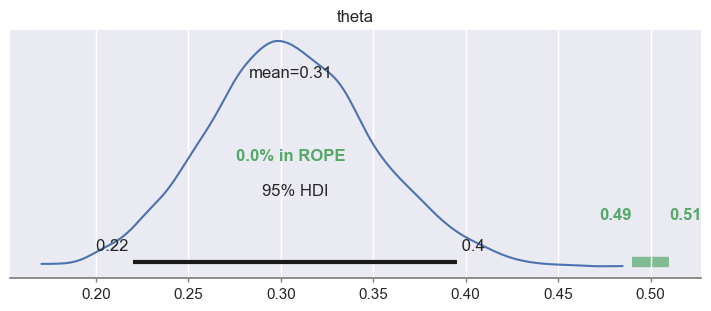

In [13]:
# We show both the 95% HDI and the rope. 
#We reject the hypothesis of the coin being practically unbiased.

az.plot_posterior (trace, rope = [0.49, 0.51], hdi_prob=0.95);


# Making decision with the ROPE
 

## Accepting the hypothesis

* A  hypothesis  is instead  *accepted* if the ROPE is contained within the HDI.
 

Example
 
    *  If the posterior HDI is  [0.48 -0.52] and the ROPE is [0.49 -0.51] we accept the hypothesis of *practical* unbiasedness.

## No strong conclusion

* If the ROPE and the HDI  partially overlap, we  cannot make a strong decision, and we might collect furher data.


* It is generally useful reporting the probability of theta belonging to the ROPE and the probability of theta not belonging to the ROPE.


# Comparing against a specific value

We can anyway compare the *posterior* with a reference value as follows:

* The plot reports the posterior mean, the probability of being smaller and larger than the reference value.

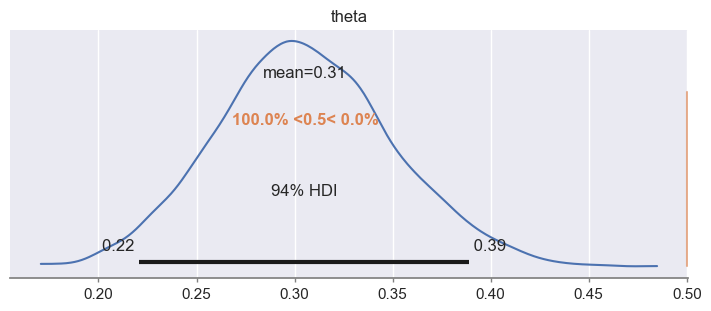

In [14]:
# the specific reference value (0.5) in this case rejected as it does not belong to the HDI.
az.plot_posterior(trace, ref_val=0.5);

# Your turn: analyze a case study.

* In a certain classification problem, a baseline classifier has accuracy 90%.


* Management thinks it makes no sense putting in production a more sophisticated classifier, unless it improves accuracy of at least 2 points. That is, algorithms with accuracy in lower than 92% are not interesting.


* In  a real test, your fancy classifier correctly predicts 48 instances out of 50.


* Which is the probability that it is improving accuracy by more than 2 points?


* Repeat the analysis for the case in which your algorithm has correctly prediction 95 instances out of 100.

# Solution in the next slides

In [15]:
#Solution
experiments = 50
n_correct = 48

# The lines within the "with" statement refer to the same model 
with pm.Model() as beta_binomial_classifier:
    #Uniform prior, i.e., Beta(1,1) 
    theta = pm.Beta('theta', alpha=1, beta=1)  
    y = pm.Binomial('y',n=experiments, p=theta, observed=n_correct) # likelihood (y successes within n_draws experiments)
    trace_classifier = pm.sample(return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


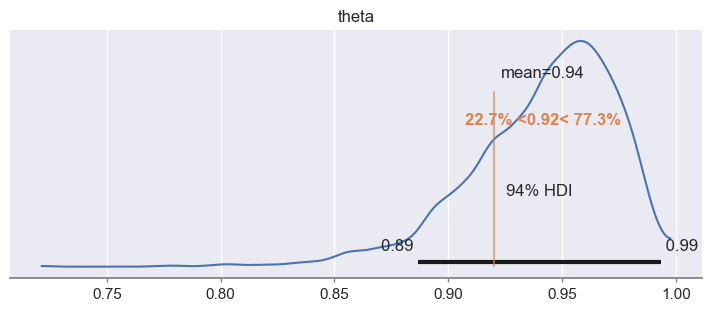

In [16]:
# according to the data, there is about 78% probability that your classifier constitutes an actual improvement
az.plot_posterior(trace_classifier, ref_val=0.92);

In [ ]:
#actually we can use a more sensible prior. We can expect the performance of our classifier to be about 90%. 
#To tune the prior, we check the 2.5 and the 97.5 percentiles obtained under different choices of a and b.
from scipy.stats import beta

qtiles = [0.025, 0.975]
for (a,b) in [(9,1), (18,2)]:
    print(a,b)
    current_qtiles = beta.ppf(qtiles, a=a, b=b)
    print(current_qtiles)

In [ ]:
# we now set the prior as beta(18,2)
with pm.Model() as beta_binomial_prior2:
    theta = pm.Beta('theta', alpha=18, beta=2)  
    y = pm.Binomial('y',n=experiments, p=theta, observed=n_correct) # likelihood (y successes within n_draws experiments)
    trace_classifier = pm.sample(return_inferencedata=True)
    az.plot_posterior(trace_classifier, ref_val=0.92);
    
# both  0.9 and 0.92 are within the HDI, so both values are plausible. With this more informative prior, the posterior probability of the classifier being larger than 92% 
#increases by a couple of points.